# Image Classification - Pap smear images for Cervical Cancer screening
**A simple implementation of a image classifier using Keras**

Data source: SipakMed https://www.kaggle.com/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

In [82]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
from PIL import Image

#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast

import warnings
warnings.filterwarnings('ignore')

Note: when replicating this code, it's possible to have some versioning issues with the imports. The reason behind is that I want to use the GPU/CUDA and TensorFlow 2.10 was the last TensorFlow release that supported GPU on native-Windows.
For more information check: https://www.tensorflow.org/install/pip#windows-native

In [83]:
# Checing if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1 - Extracting images

For simplicty I already extracted the data from Kaggle to a local archive.zip file.

You can do the same by following this guide: https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/

In [10]:
# Let's extract our images in archive.zip
def extract_cropped_images(zip_path, extraction_path):
    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as archive:
        # Iterate through each file
        for file_info in archive.infolist():
            # Check if the file is a .bmp file within a CROPPED subfolder
            if file_info.filename.endswith('.bmp') and 'CROPPED' in file_info.filename:
                # Split the path to get the necessary components
                parts = file_info.filename.split('/')
                # Extract the first subfolder name as the label
                label = parts[1]
                # Get the image filename
                image_filename = parts[-1]
                # Destination path
                destination_dir = os.path.join(extraction_path, label)
                destination_path = os.path.join(destination_dir, image_filename)
                # Create the directory (if it doesn't exist)
                os.makedirs(destination_dir, exist_ok=True)
                # Extract the images
                with archive.open(file_info) as source_file:
                    with open(destination_path, 'wb') as dest_file:
                        shutil.copyfileobj(source_file, dest_file)
    print(f"Images extracted!")

TLDR: we just want to grab the *images.bmp* from the **CROPPED** folder inside the *archive.zip* file. And we want to keep these images inside their respective subfolders - these subfolders represent the target labels.

In [11]:
zip_path = 'archive.zip'
extraction_path = 'cropped_images'

In [12]:
extract_cropped_images(zip_path, extraction_path)

Images extracted!


In [16]:
# Checking the number of images of each label
for subfolder in os.listdir(extraction_path):
        subfolder_path = os.path.join(extraction_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count the number of .bmp files in the subfolder
            num_images = len([name for name in os.listdir(subfolder_path) if name.endswith('.bmp')])
            print(f"{num_images} images in '{subfolder}'.")

813 images in 'Dyskeratotic'.
825 images in 'Koilocytotic'.
793 images in 'Metaplastic'.
787 images in 'Parabasal'.
831 images in 'Superficial_Intermediate'.


# 2 - Training, Validation and Test datasets

In [85]:
# Defining image size and batch size
img_width, img_height = 256, 256
batch_size = 64

In [86]:
# Training and "Validation" datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_images",
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=183
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_images",
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=183
)

Found 4049 files belonging to 5 classes.
Using 3240 files for training.
Found 4049 files belonging to 5 classes.
Using 809 files for validation.


In [87]:
# Training and "Validation" datasets batches
print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(val_ds)} batches")

Training dataset: 51 batches
Validation dataset: 13 batches


In [88]:
# Splitting Validation and Test datasets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

In [89]:
# Training, Validation and Test datasets ~ 80/10/10
print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(val_ds)} batches")
print(f"Testing dataset: {len(test_ds)} batches")

Training dataset: 51 batches
Validation dataset: 7 batches
Testing dataset: 6 batches


In [90]:
# Our 5 classes (target labels)
class_names = train_ds.class_names
class_names

['Dyskeratotic',
 'Koilocytotic',
 'Metaplastic',
 'Parabasal',
 'Superficial_Intermediate']

In [91]:
# Example of a batch
for img, label in train_ds:
    print(img.shape, label)
    break

(64, 256, 256, 3) tf.Tensor(
[2 2 2 0 0 2 1 2 0 1 1 4 3 0 3 3 0 0 3 4 4 2 1 4 4 2 1 2 0 2 0 0 0 4 2 2 4
 0 1 2 1 1 4 2 4 3 3 3 2 0 2 0 0 2 3 3 2 0 1 2 3 0 4 0], shape=(64,), dtype=int32)


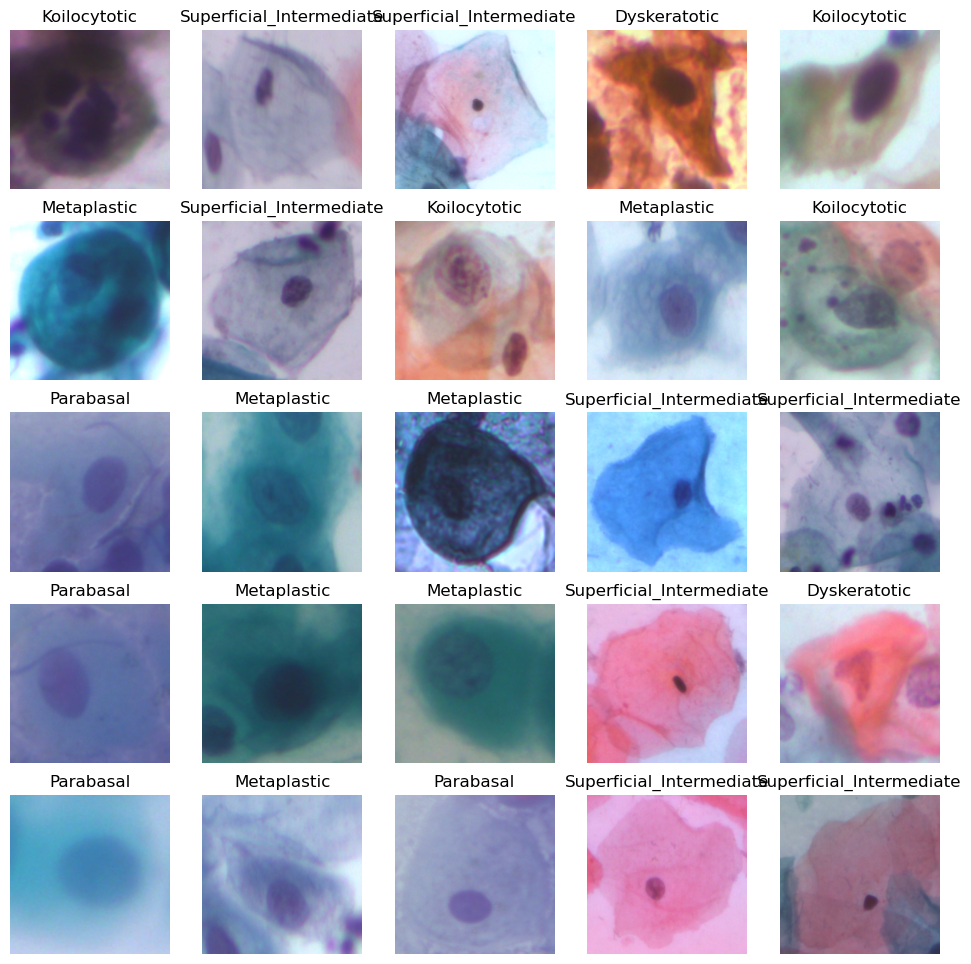

In [92]:
# Visualizing some training images
plt.figure(figsize=(12,12))
for img, label in train_ds:
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')
    break

In [93]:
train_ds = train_ds.cache().shuffle(len(train_ds)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(len(train_ds)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# 3 - Preprocessing

In [94]:
resize_and_rescale = Sequential([
    Resizing(img_width, img_height),
    Rescaling(1./255)
])

In [95]:
data_augmentation = Sequential([
    RandomFlip(mode='horizontal_and_vertical'),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.2),
    RandomRotation(0.2)
])

# 4 - Model training

In [96]:
input_shape = (batch_size, img_width, img_height, 3)
n_classes = 5

In [97]:
# Building a CNN model
model = Sequential([

    resize_and_rescale,
    data_augmentation,
    
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    Dense(5, activation='softmax')
])

model.build(input_shape=input_shape)

In [98]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 sequential_8 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (64, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (64, 127, 127, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (64, 63, 63, 64)         0         
 2D)                                                  

In [99]:
# Compile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt_adam = Adam(learning_rate=0.001)

model.compile(optimizer=opt_adam, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [100]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback - save best weights
chekpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

In [102]:
# Train the model
history = model.fit(train_ds,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=val_ds,
                    callbacks=[early_stop, chekpoint],
                    verbose=1)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.4463
Epoch 1: val_loss improved from inf to 1.13223, saving model to best_weights.hdf5
51/51 [==============================] - 104s 2s/step - loss: 1.2730 - accuracy: 0.4463 - val_loss: 1.1322 - val_accuracy: 0.4753
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.5506
Epoch 2: val_loss improved from 1.13223 to 1.01728, saving model to best_weights.hdf5
51/51 [==============================] - 124s 2s/step - loss: 1.1072 - accuracy: 0.5506 - val_loss: 1.0173 - val_accuracy: 0.5812
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.9962 - accuracy: 0.6151
Epoch 3: val_loss improved from 1.01728 to 0.96883, saving model to best_weights.hdf5
51/51 [==============================] - 124s 2s/step - loss: 0.9962 - accuracy: 0.6151 - val_loss: 0.9688 - val_accuracy: 0.6094
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 0.

# 5 - Model testing and Predictions

In [103]:
# Evaluate the model
model.load_weights('best_weights.hdf5')
loss, accuracy = model.evaluate(test_ds)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 1s 44ms/step - loss: 0.2666 - accuracy: 0.8958
Test Loss: 0.26655682921409607
Test Accuracy: 0.8958333134651184


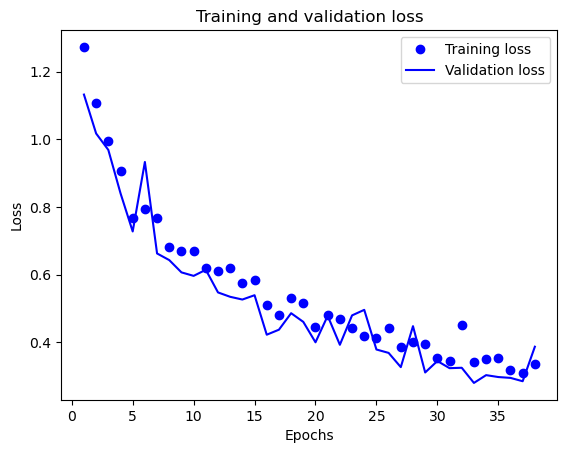

In [104]:
# Loss visualiztion
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
from keras.utils import img_to_array, load_img

def predictions(model, img):
    img_array = img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


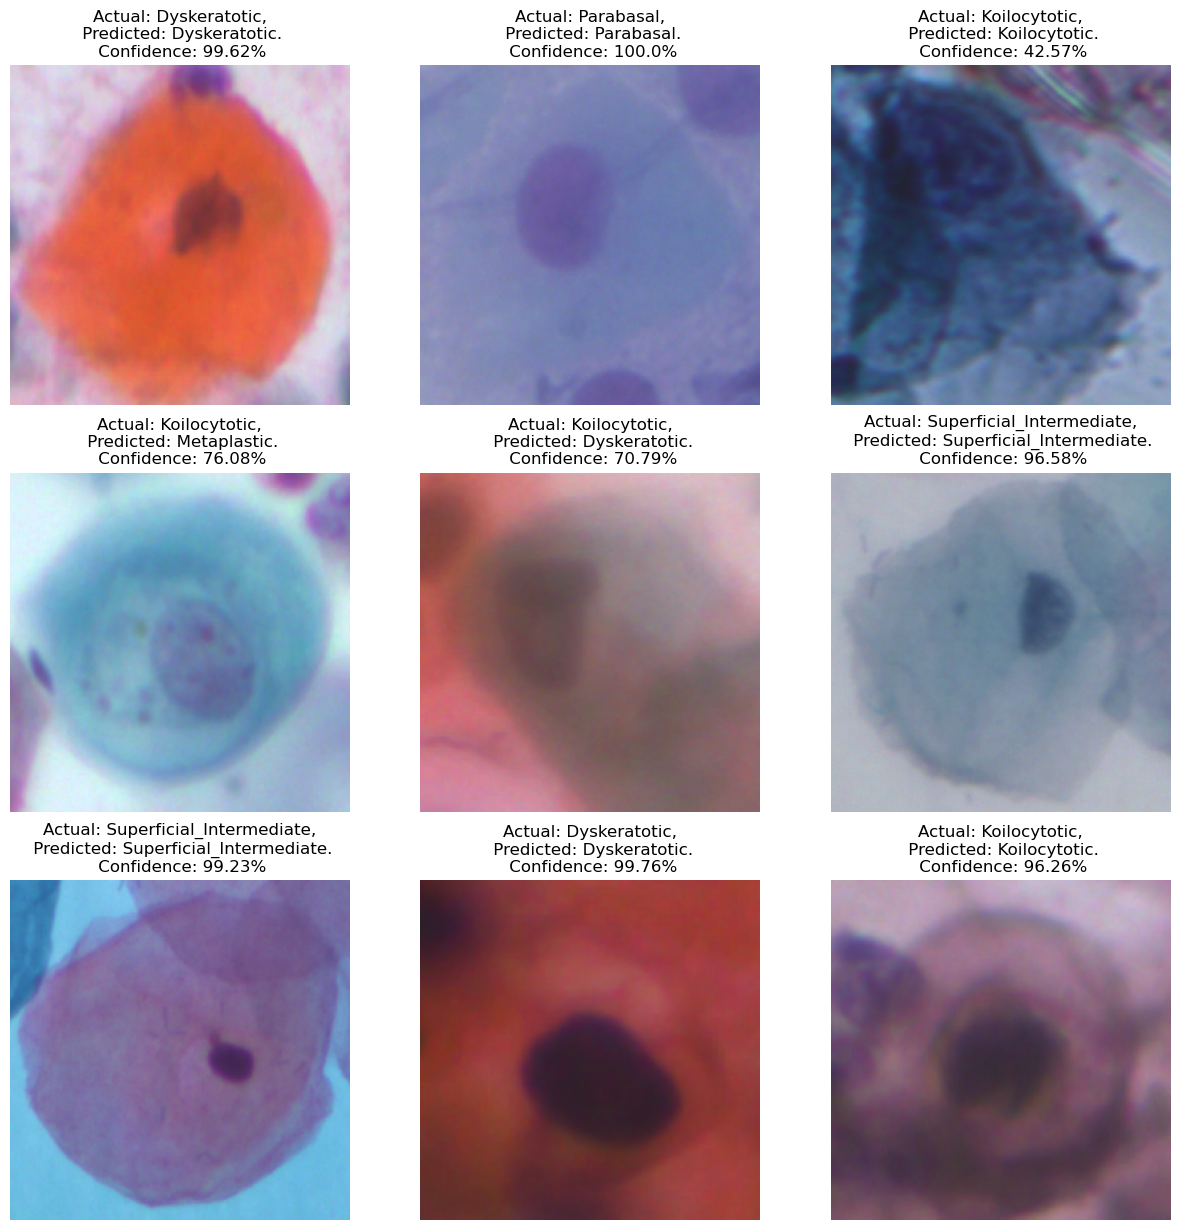

In [106]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predictions(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# 6 - Save the model

In [107]:
model_version = max([int(i) for i in os.listdir("saved_models") + [0]])+1
model.save(f"saved_models/{model_version}")

INFO:tensorflow:Assets written to: saved_models/5\assets


INFO:tensorflow:Assets written to: saved_models/5\assets


In [108]:
# Or just save it directly with chosen name
model.save("cytology_5.h5")